In [1]:
# Import necessary modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import optuna
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, KFold, cross_validate, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, RocCurveDisplay)
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from optuna.pruners import MedianPruner
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Input  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from optuna.samplers import TPESampler
from tensorflow.keras.layers import Input
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import randint, loguniform, uniform
import numpy as np


# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### LOAD AND CHECK DATA

In [2]:
# Load the data
airline_data = pd.read_csv(r"C:\Users\YILMAZ\Desktop\final_airplane_data.csv")

In [3]:
# Dataset Info
print(f"Shape: {airline_data.shape}")
print(f"Columns: {list(airline_data.columns)}")

Shape: (119255, 22)
Columns: ['satisfaction', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding', 'Departure Delay Winsorized', 'Arrival Delay Winsorized']


In [4]:
# Data Types
airline_data.dtypes

satisfaction                          object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay Winsorized             int64
Arrival Delay Winsorized             float64
dtype: obj

In [5]:
# First rows
airline_data.head()

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay Winsorized,Arrival Delay Winsorized
0,dissatisfied,Loyal Customer,48,Personal Travel,Eco,4001,1,1,1,1,1,1,1,1,4,1,1,4,2,1,16,0.000
1,dissatisfied,Loyal Customer,48,Personal Travel,Eco,3980,1,1,1,1,4,1,4,4,2,3,2,3,2,4,0,0.000
2,dissatisfied,Loyal Customer,40,Personal Travel,Eco,2251,1,1,1,1,1,1,1,1,3,3,2,1,1,1,0,8.000
3,dissatisfied,Loyal Customer,46,Personal Travel,Eco,2453,1,1,1,1,3,1,5,3,1,4,1,2,2,3,3,15.000
4,dissatisfied,Loyal Customer,63,Personal Travel,Eco,2011,1,1,1,1,5,1,5,5,1,5,2,1,2,5,25,25.000


In [6]:
# Missing Values
airline_data.isnull().sum()

satisfaction                         0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Seat comfort                         0
Departure/Arrival time convenient    0
Food and drink                       0
Gate location                        0
Inflight wifi service                0
Inflight entertainment               0
Online support                       0
Ease of Online booking               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Cleanliness                          0
Online boarding                      0
Departure Delay Winsorized           0
Arrival Delay Winsorized             0
dtype: int64

In [7]:
# Target Variable Distribution
target_dist = airline_data["satisfaction"].value_counts(normalize = True) * 100   # value_counts() counts each unique value; normalize=True gives proportions instead of counts.
print(target_dist)

satisfaction
satisfied      54.144
dissatisfied   45.856
Name: proportion, dtype: float64


In [8]:
# values of categorical variables
categorical_cols = airline_data.select_dtypes(include=["object", "category"]).columns
for col in categorical_cols:
    print(airline_data[col].unique())

['dissatisfied' 'satisfied']
['Loyal Customer' 'disloyal Customer']
['Personal Travel' 'Business travel']
['Eco' 'Business' 'Eco Plus']


### TRAIN-TEST SPLIT

In [9]:
# Separate features and target
X = airline_data.drop("satisfaction", axis = 1)
y = airline_data["satisfaction"]

# Split the data (%80 train and %20 test)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train_raw.shape[0]} samples")
print(f"Testing set size: {X_test_raw.shape[0]} samples")
print(f"\nTarget distribution in training set:")
print(y_train.value_counts(normalize=True))
print(f"\nTarget distribution in testing set:")
print(y_test.value_counts(normalize=True))

Training set size: 95404 samples
Testing set size: 23851 samples

Target distribution in training set:
satisfaction
satisfied      0.541
dissatisfied   0.459
Name: proportion, dtype: float64

Target distribution in testing set:
satisfaction
satisfied      0.541
dissatisfied   0.459
Name: proportion, dtype: float64


### PREPROCESSING PIPELINE

In [10]:
def preprocess_for_nn_ohe_scale(X_train, X_test, drop_first=False):
    """
    Preprocess data for Neural Networks using:
    - One-Hot Encoding for categorical variables
    - Standard Scaling for numerical variables
    - Leakage-safe: fit ONLY on training data
    """

    # Identify columns
    categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
    numerical_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

    # Numeric pipeline (scale numeric features)
    numeric_transformer = Pipeline(steps=[
        ("scaler", StandardScaler())
    ])

    # Categorical pipeline (one-hot)
    categorical_transformer = Pipeline(steps=[
        ("onehot", OneHotEncoder(
            drop="first" if drop_first else None,
            handle_unknown="ignore",
            sparse_output=False
        ))
    ])

    # Combine transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numerical_cols),
            ("cat", categorical_transformer, categorical_cols)
        ],
        remainder="drop"
    )

    # Fit ONLY on training, transform both
    X_train_arr = preprocessor.fit_transform(X_train)
    X_test_arr = preprocessor.transform(X_test)

    # Build feature names (useful for debugging/reporting)
    cat_feature_names = []
    if len(categorical_cols) > 0:
        cat_feature_names = list(
            preprocessor.named_transformers_["cat"]
            .named_steps["onehot"]
            .get_feature_names_out(categorical_cols)
        )
    feature_names = numerical_cols + cat_feature_names

    # Convert to DataFrame
    X_train_final = pd.DataFrame(X_train_arr, columns=feature_names, index=X_train.index)
    X_test_final = pd.DataFrame(X_test_arr, columns=feature_names, index=X_test.index)

    return X_train_final, X_test_final, preprocessor

In [11]:
# Features
X_train_nn, X_test_nn, nn_preprocessor = preprocess_for_nn_ohe_scale(
    X_train_raw, X_test_raw, drop_first=False
)

# Target 
le_target = LabelEncoder()
y_train_nn = le_target.fit_transform(y_train)
y_test_nn = le_target.transform(y_test)

print("X_train_nn shape:", X_train_nn.shape)
print("X_test_nn shape:", X_test_nn.shape)
print("Classes:", le_target.classes_.tolist())

X_train_nn shape: (95404, 25)
X_test_nn shape: (23851, 25)
Classes: ['dissatisfied', 'satisfied']


- Categorical and numerical features are automatically identified based on their data types.

- Numerical features are standardized using StandardScaler to ensure zero mean and unit variance, which improves convergence and stability in neural network training.

- Categorical features are transformed using One-Hot Encoding:
  - `drop_first=False` keeps all dummy variables, which is appropriate for neural networks.
  - `handle_unknown="ignore"` prevents errors when unseen categories appear in the test set.
  - `sparse_output=False` ensures dense output for easier conversion to pandas DataFrames.

- Numerical and categorical transformations are combined using a ColumnTransformer, allowing different preprocessing steps to be applied to different feature types.

- Preprocessing is leakage-safe:
  - The preprocessing pipeline is fitted only on the training data.
  - The test data is transformed using the fitted pipeline without refitting.

- Feature names generated after One-Hot Encoding are extracted and preserved to maintain interpretability and support debugging.

- The transformed feature matrices are converted into pandas DataFrames while preserving the original row indices.

- The fitted preprocessing pipeline is returned to allow consistent transformation of future or unseen data.

### NEURAL NETWORK MODEL - BASIC (DEFAULT PARAMETERS)

In [12]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_nn, y_train_nn,
    test_size=0.2,
    random_state=42,
    stratify=y_train_nn
)

# Convert to numpy float32 (recommended for Keras)
X_tr = X_tr.to_numpy(dtype=np.float32)
X_val = X_val.to_numpy(dtype=np.float32)
X_test_np = X_test_nn.to_numpy(dtype=np.float32)

input_dim = X_tr.shape[1]

# Build basic NN
def build_basic_nn(input_dim):
    model = Sequential([
        Dense(64, activation="relu", input_shape=(input_dim,), name="dense_1"),
        Dense(32, activation="relu", name="dense_2"),
        Dense(1, activation="sigmoid", name="dense_output")
    ])
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

basic_nn = build_basic_nn(input_dim)

print("\nBasic Neural Network Architecture:")
basic_nn.summary()

# Train with EarlyStopping
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_basic = basic_nn.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)

# Predictions (probabilities)
y_train_proba_basic = basic_nn.predict(X_tr, verbose=0).ravel()
y_val_proba_basic   = basic_nn.predict(X_val, verbose=0).ravel()
y_test_proba_basic  = basic_nn.predict(X_test_np, verbose=0).ravel()

# Threshold at 0.5
y_train_pred_basic = (y_train_proba_basic >= 0.5).astype(int)
y_val_pred_basic   = (y_val_proba_basic   >= 0.5).astype(int)
y_test_pred_basic  = (y_test_proba_basic  >= 0.5).astype(int)

def print_metrics(y_true, y_pred, y_proba, name="Set"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted")
    rec = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")
    auc = roc_auc_score(y_true, y_proba)

    print(f"\n{name} Performance:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  AUC:       {auc:.4f}")

# Train / Val / Test metrics
print_metrics(y_tr, y_train_pred_basic, y_train_proba_basic, "Basic NN - Train")
print_metrics(y_val, y_val_pred_basic, y_val_proba_basic, "Basic NN - Val")
print_metrics(y_test_nn, y_test_pred_basic, y_test_proba_basic, "Basic NN - Test")


Basic Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 64)                  │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_output (Dense)                 │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,777 (14.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9045 - loss: 0.2208 - val_accuracy: 0.9246 - val_loss: 0.1742
Epoch 2/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9296 - loss: 0.1643 - val_accuracy: 0.9317 - val_loss: 0.1537
Epoch 3/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9372 - loss: 0.1447 - val_accuracy: 0.9370 - val_loss: 0.1412
Epoch 4/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9425 - loss: 0.1328 - val_accuracy: 0.9408 - val_loss: 0.1332
Epoch 5/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9453 - loss: 0.1253 - val_accuracy: 0.9421 - val_loss: 0.1287
Epoch 6/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9471 - loss: 0.1204 - val_accuracy: 0.9438 - val_loss: 0.1257
Epoch 7/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9482 - loss: 0.1169 - val_accuracy: 0.9440 - val_loss: 0.1248
Epoch 8/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9492 - loss: 0.1140 - 

### PLOT TRAINING HISTORY

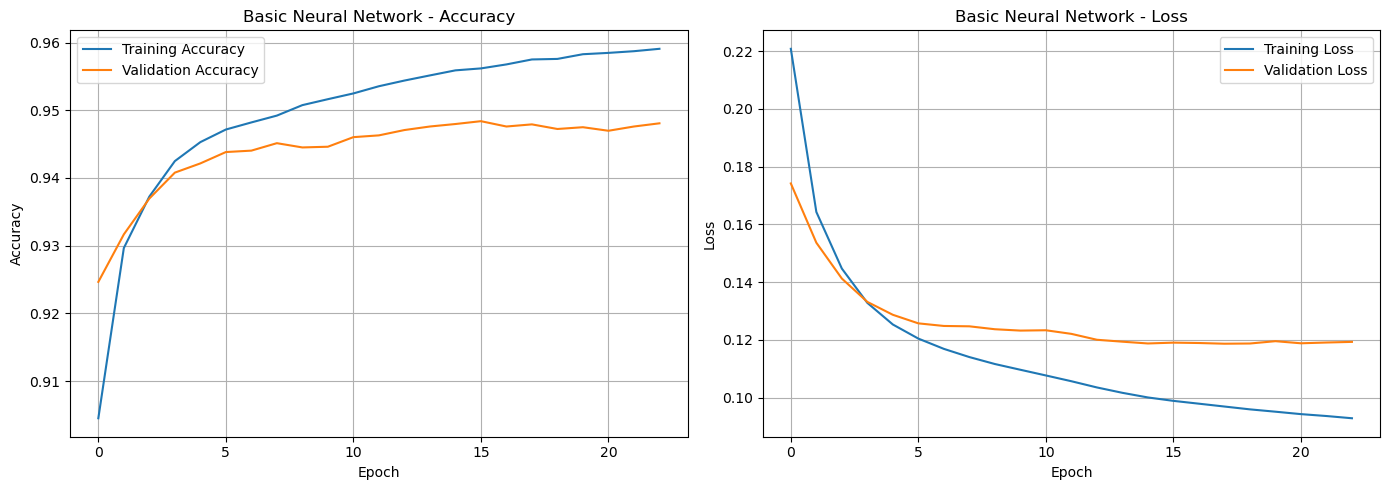

In [13]:
# Plot training history
def plot_training_history(history, title="Training History"):
    """
    Plot training and validation accuracy and loss
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title(f'{title} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title(f'{title} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_basic, "Basic Neural Network")

- The learning curves indicate stable and effective training, with no signs of severe overfitting. Training and validation performance improve consistently and converge smoothly, suggesting good generalization capability of the neural network.

### HYPERPARAMETER TUNING WITH CROSS-VALIDATION

In [14]:
# Hyperparameters suggested by Optuna trials
def build_nn_optuna(trial, input_dim):
    n_hidden = trial.suggest_int("n_hidden", 1, 4)
    n_neurons = trial.suggest_categorical("n_neurons", [32, 64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    model = Sequential()
    model.add(Dense(n_neurons, activation="relu", input_shape=(input_dim,)))

    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    for _ in range(n_hidden - 1):
        model.add(Dense(n_neurons, activation="relu"))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


# Hyperparameter Tuning with Stratified K-Fold Cross-Validation
def objective(trial):
    tf.keras.backend.clear_session()

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in skf.split(X_train_raw, y_train_nn):

        # Split RAW data
        X_tr_raw = X_train_raw.iloc[train_idx]
        X_val_raw = X_train_raw.iloc[val_idx]
        y_tr = y_train_nn[train_idx]
        y_val = y_train_nn[val_idx]

        #  Fit preprocessing ONLY on train fold
        X_tr_proc, X_val_proc, _ = preprocess_for_nn_ohe_scale(
            X_tr_raw, X_val_raw
        )

        X_tr = X_tr_proc.to_numpy(np.float32)
        X_val = X_val_proc.to_numpy(np.float32)

        model = build_nn_optuna(trial, input_dim=X_tr.shape[1])

        early_stop = EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=0
        )

        model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=trial.suggest_categorical("batch_size", [32, 64, 128]),
            callbacks=[early_stop],
            verbose=0
        )

        y_val_proba = model.predict(X_val, verbose=0).ravel()
        auc_scores.append(roc_auc_score(y_val, y_val_proba))

    return np.mean(auc_scores)
    

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("Best CV AUC:", study.best_value)
print("Best params:", study.best_params)

[I 2026-01-01 15:13:44,552] A new study created in memory with name: no-name-d81f4451-53f9-44e7-acc7-a52a6e888316


  0%|          | 0/30 [00:00<?, ?it/s]


[I 2026-01-01 15:21:28,104] Trial 0 finished with value: 0.99200559109742 and parameters: {'n_hidden': 3, 'n_neurons': 128, 'dropout_rate': 0.1659382182713552, 'learning_rate': 0.00011241014703144869, 'batch_size': 64}. Best is trial 0 with value: 0.99200559109742.
[I 2026-01-01 15:28:42,875] Trial 1 finished with value: 0.9888996905057853 and parameters: {'n_hidden': 1, 'n_neurons': 32, 'dropout_rate': 0.032596421193055, 'learning_rate': 0.0028082690578964424, 'batch_size': 32}. Best is trial 0 with value: 0.99200559109742.
[I 2026-01-01 15:33:11,798] Trial 2 finished with value: 0.9905530608945486 and parameters: {'n_hidden': 4, 'n_neurons': 64, 'dropout_rate': 0.4440455698932998, 'learning_rate': 0.0019886349150254577, 'batch_size': 64}. Best is trial 0 with value: 0.99200559109742.
[I 2026-01-01 15:43:23,560] Trial 3 finished with value: 0.9889914832268024 and parameters: {'n_hidden': 1, 'n_neurons': 256, 'dropout_rate': 0.05394008060328076, 'learning_rate': 0.00012350784695659486

In [15]:
# Train final tuned model (pipeline) on full training data
best = study.best_params

final_nn = Sequential()
final_nn.add(Dense(best["n_neurons"], activation="relu", input_shape=(input_dim,)))

if best["dropout_rate"] > 0:
    final_nn.add(Dropout(best["dropout_rate"]))

for _ in range(best["n_hidden"] - 1):
    final_nn.add(Dense(best["n_neurons"], activation="relu"))
    if best["dropout_rate"] > 0:
        final_nn.add(Dropout(best["dropout_rate"]))

final_nn.add(Dense(1, activation="sigmoid"))

final_nn.compile(
    optimizer=Adam(learning_rate=best["learning_rate"]),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history_final = final_nn.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=best["batch_size"],
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9007 - loss: 0.2292 - val_accuracy: 0.9276 - val_loss: 0.1701
Epoch 2/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9266 - loss: 0.1718 - val_accuracy: 0.9384 - val_loss: 0.1458
Epoch 3/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9343 - loss: 0.1512 - val_accuracy: 0.9432 - val_loss: 0.1320
Epoch 4/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9399 - loss: 0.1372 - val_accuracy: 0.9465 - val_loss: 0.1233
Epoch 5/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9442 - loss: 0.1296 - val_accuracy: 0.9484 - val_loss: 0.1180
Epoch 6/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9454 - loss: 0.1249 - val_accuracy: 0.9494 - val_loss: 0.1159
Epoch 7/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9474 - loss: 0.1208 - val_accuracy: 0.9507 - val_loss: 0.1126
Epoch 8/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9474 - loss: 0

In [17]:
# Make predictions with final model
y_train_proba_final = final_nn.predict(X_tr, verbose=0).ravel()
y_val_proba_final = final_nn.predict(X_val, verbose=0).ravel()
y_test_proba_final = final_nn.predict(X_test_np, verbose=0).ravel()

# Threshold at 0.5
y_train_pred_final = (y_train_proba_final >= 0.5).astype(int)
y_val_pred_final = (y_val_proba_final >= 0.5).astype(int)
y_test_pred_final = (y_test_proba_final >= 0.5).astype(int)

print_metrics(y_tr, y_train_pred_final, y_train_proba_final, "Final NN - Train")
print_metrics(y_val, y_val_pred_final, y_val_proba_final, "Final NN - Validation")
print_metrics(y_test_nn, y_test_pred_final, y_test_proba_final, "Final NN - Test")


Final NN - Train Performance:
  Accuracy:  0.9645
  Precision: 0.9648
  Recall:    0.9645
  F1-Score:  0.9645
  AUC:       0.9960

Final NN - Validation Performance:
  Accuracy:  0.9570
  Precision: 0.9574
  Recall:    0.9570
  F1-Score:  0.9570
  AUC:       0.9937

Final NN - Test Performance:
  Accuracy:  0.9568
  Precision: 0.9572
  Recall:    0.9568
  F1-Score:  0.9569
  AUC:       0.9939


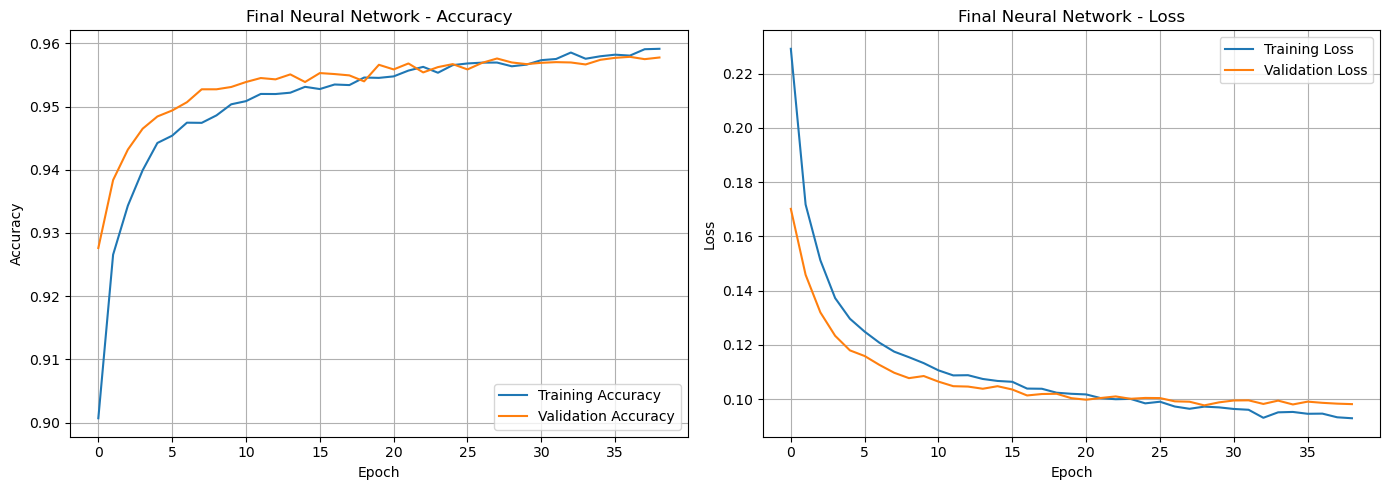

In [19]:
plot_training_history(history_final, "Final Neural Network")

- The final neural network exhibits stable and well-balanced learning behavior. Training and validation accuracy converge closely without divergence, while validation loss consistently decreases and stabilizes. This indicates strong generalization performance and no evidence of overfitting, confirming the effectiveness of the selected hyperparameters and regularization strategy.

In [30]:
# Class names from LabelEncoder
class_names = le_target.classes_.tolist()

print("Classification Report - Final Neural Network:")
print(
    classification_report(
        y_test_nn,          # true labels
        y_test_pred_final,  # NN predicted labels (0/1)
        target_names=class_names
    )
)

Classification Report - Final Neural Network:
              precision    recall  f1-score   support

dissatisfied       0.94      0.97      0.95     10937
   satisfied       0.97      0.95      0.96     12914

    accuracy                           0.96     23851
   macro avg       0.96      0.96      0.96     23851
weighted avg       0.96      0.96      0.96     23851



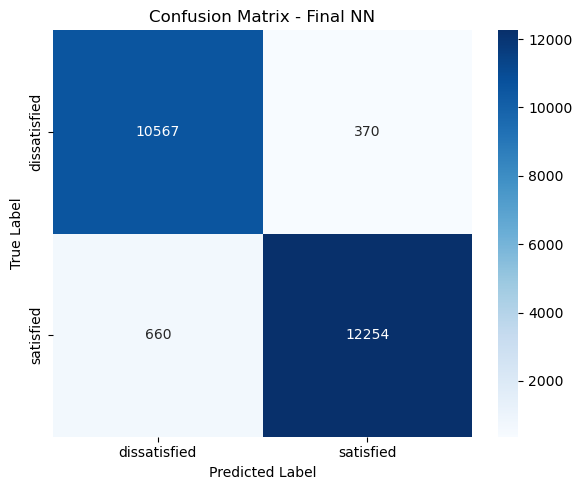

In [24]:
cm = confusion_matrix(y_test_nn, y_test_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=class_names, yticklabels=class_names
)
plt.title("Confusion Matrix - Final NN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


AUC Score (Test): 0.9939


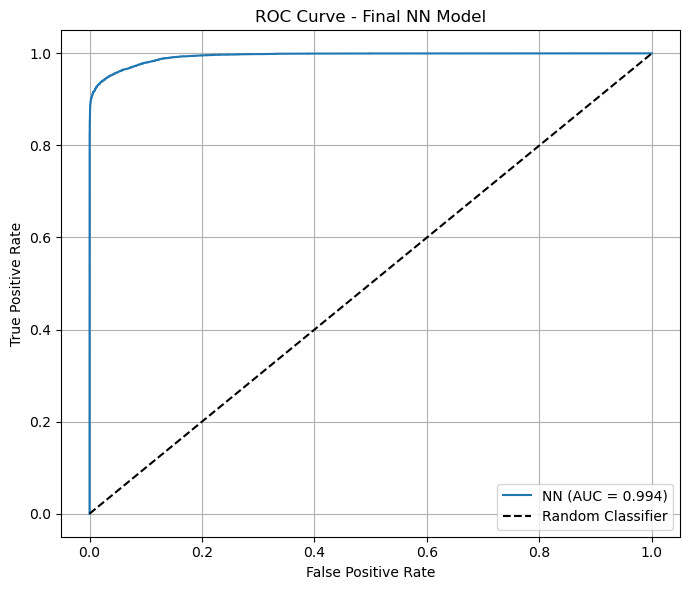

In [25]:
auc_score = roc_auc_score(y_test_nn, y_test_proba_final)
print(f"\nAUC Score (Test): {auc_score:.4f}")

fpr, tpr, _ = roc_curve(y_test_nn, y_test_proba_final)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"NN (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.title("ROC Curve - Final NN Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
train_acc = accuracy_score(y_tr, y_train_pred_final)
test_acc  = accuracy_score(y_test_nn, y_test_pred_final)

train_auc = roc_auc_score(y_tr, y_train_proba_final)
test_auc  = roc_auc_score(y_test_nn, y_test_proba_final)

print("\nNN Overfitting Analysis")
print("-" * 30)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
print(f"Difference:        {abs(train_acc - test_acc):.4f}")
print("-" * 30)
print(f"Training AUC:      {train_auc:.4f}")
print(f"Testing AUC:       {test_auc:.4f}")
print(f"Difference:        {abs(train_auc - test_auc):.4f}")


NN Overfitting Analysis
------------------------------
Training Accuracy: 0.9645
Testing Accuracy:  0.9568
Difference:        0.0077
------------------------------
Training AUC:      0.9960
Testing AUC:       0.9939
Difference:        0.0021


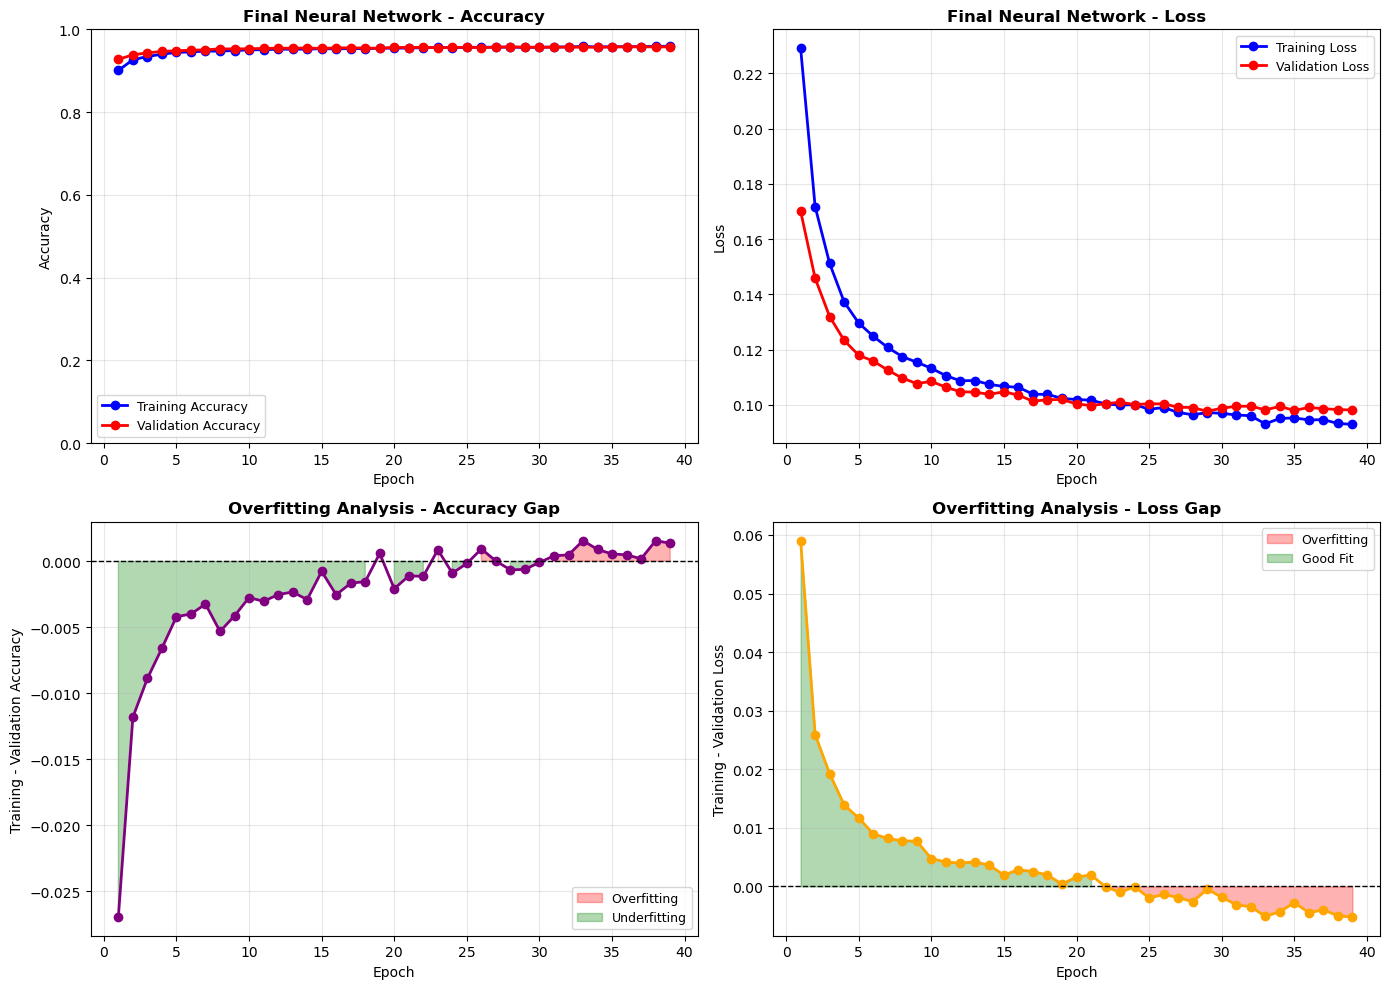

In [32]:
# Additional detailed learning curve analysis
def plot_detailed_learning_curves(history, title="Detailed Learning Curves"):
    """
    Plot comprehensive learning curves with multiple metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Accuracy plot
    axes[0, 0].plot(epochs, history.history['accuracy'], 'o-', label='Training Accuracy', color='blue', linewidth=2)
    axes[0, 0].plot(epochs, history.history['val_accuracy'], 'o-', label='Validation Accuracy', color='red', linewidth=2)
    axes[0, 0].set_title(f'{title} - Accuracy', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=10)
    axes[0, 0].set_ylabel('Accuracy', fontsize=10)
    axes[0, 0].legend(fontsize=9)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0, 1])
    
    # Loss plot
    axes[0, 1].plot(epochs, history.history['loss'], 'o-', label='Training Loss', color='blue', linewidth=2)
    axes[0, 1].plot(epochs, history.history['val_loss'], 'o-', label='Validation Loss', color='red', linewidth=2)
    axes[0, 1].set_title(f'{title} - Loss', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=10)
    axes[0, 1].set_ylabel('Loss', fontsize=10)
    axes[0, 1].legend(fontsize=9)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Gap analysis (Overfitting detection)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    gap = np.array(train_acc) - np.array(val_acc)
    
    axes[1, 0].plot(epochs, gap, 'o-', color='purple', linewidth=2)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[1, 0].set_title('Overfitting Analysis - Accuracy Gap', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=10)
    axes[1, 0].set_ylabel('Training - Validation Accuracy', fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].fill_between(epochs, 0, gap, where=(gap > 0), alpha=0.3, color='red', label='Overfitting')
    axes[1, 0].fill_between(epochs, 0, gap, where=(gap <= 0), alpha=0.3, color='green', label='Underfitting')
    axes[1, 0].legend(fontsize=9)
    
    # Loss gap
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    loss_gap = np.array(train_loss) - np.array(val_loss)
    
    axes[1, 1].plot(epochs, loss_gap, 'o-', color='orange', linewidth=2)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[1, 1].set_title('Overfitting Analysis - Loss Gap', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontsize=10)
    axes[1, 1].set_ylabel('Training - Validation Loss', fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].fill_between(epochs, 0, loss_gap, where=(loss_gap < 0), alpha=0.3, color='red', label='Overfitting')
    axes[1, 1].fill_between(epochs, 0, loss_gap, where=(loss_gap >= 0), alpha=0.3, color='green', label='Good Fit')
    axes[1, 1].legend(fontsize=9)
    
    plt.tight_layout()
    plt.show()

plot_detailed_learning_curves(history_final, "Final Neural Network")

- Training & Validation Accuracy: The training and validation accuracy curves increase rapidly during the initial epochs and stabilize at a high and similar level. The close alignment of the two curves throughout the training process indicates that the neural network learns the underlying patterns effectively without exhibiting signs of overfitting or underfitting.

- Training & Validation Loss: The training and validation loss curves decrease smoothly and in parallel across epochs, with no divergence observed. This behavior suggests stable optimization and indicates that the model generalizes well to unseen data, as the validation loss does not increase while the training loss continues to decrease.

- Overfitting Analysis – Accuracy Gap: The accuracy gap between training and validation remains close to zero across epochs, with only minor fluctuations. This demonstrates a well-balanced bias–variance trade-off and confirms that the model does not suffer from overfitting or underfitting during training.

- Overfitting Analysis – Loss Gap: The difference between training and validation loss converges rapidly toward zero and remains negligible throughout the training process. The absence of a persistent positive loss gap indicates that the model maintains strong generalization performance and does not overfit the training data.

Overall, the neural network demonstrates stable learning behavior with consistent performance across training and validation sets. The combined analysis of accuracy and loss curves confirms that the final model achieves a robust and reliable generalization capability.


## Overfitting

No significant overfitting is observed; the model exhibits a well-controlled learning behavior.

The observed gaps:

- Are minimal and remain close to zero throughout training.
- Indicate a strong balance between model capacity and regularization mechanisms (e.g., dropout and early stopping).

The parallel evolution of training and validation metrics:

- Confirms that the model does not memorize the training data.
- Demonstrates stable and consistent generalization performance.

Overall, the model:

- Learns the training data effectively,
- While maintaining a high level of generalization capability on unseen data.

## Data Leakage

No evidence of data leakage is observed.

During preprocessing:

- Feature scaling and encoding are fitted exclusively on the training data.
- Validation and test sets are transformed using the already fitted preprocessing objects.

During model training and validation:

- The validation set is kept strictly separate from the training process.
- Early stopping monitors validation loss without leaking validation labels into training.

During model evaluation:

- Model performance is assessed independently on the test set.
- The test set is never used for hyperparameter tuning or model selection.

The fact that training, validation, and testing performances:

- Are close but not identical,
- Provides further evidence that data leakage is not present.
